In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

In [67]:
#chordonomicon dataset has spotify ID, while hot 100 has names only. Goal is to use Spotify API (connect Spotify ID -> name) to connect hot 100 songs 
#to their spotify ID and see how many are in the chordonomicon dataset 

hot_100 = pd.read_csv("hot-100-current.csv")
spotify = pd.read_csv("spotify_final.csv").drop_duplicates(subset=["track_name", "artist_name"])
spotify = spotify.loc[:, ~spotify.columns.str.contains('^Unnamed')]

print(spotify.shape)
print(hot_100.shape)

(214878, 13)
(350500, 7)


In [68]:
print(spotify.columns)
print(hot_100.columns)

spotify

#spotify 'track_name' column == hot 100 'title' 
#spotify 'artist_name' column == hot 100 'performer'

Index(['track_id', 'artist_id', 'success', 'track_name', 'artists',
       'album_name', 'release_date', 'popularity', 'duration_ms',
       'artist_name', 'genres', 'artist_popularity', 'followers'],
      dtype='object')
Index(['chart_week', 'current_week', 'title', 'performer', 'last_week',
       'peak_pos', 'wks_on_chart'],
      dtype='object')


,track_id,artist_id,success,track_name,artists,album_name,release_date,popularity,duration_ms,artist_name,genres,artist_popularity,followers
0,0mq9OkzL86LzLEHXdq97pj,7ceUfdWq2t5nbatS6ollHh,True,Tell Me That You Love Me - Remastered,Paul Anka,Paul Anka Sings His Big 15 (Vol. 2 / Remastered),1961-01-01,12,132773,Paul Anka,adult standards,60,820612
1,4bXvEKd0wszs1N6M831MXo,6ra4GIOgCZQZMOaUECftGN,True,For The Young Sophisticate,Frank Zappa,Tinseltown Rebellion,1981-05-17,0,193840,Frank Zappa,"progressive rock, art rock, psychedelic rock, ...",54,1026728
2,0ClOqpNWoov7Pc04mEYePM,1WUdtysXvz9qXuD6toSJqA,True,Sleep Station,Chicosci,This Is Not A Chicosci Record (Secret Weapons ...,2012-01-01,5,286440,Chicosci,"pinoy rock, opm, pinoy alternative, rap metal",36,188645
3,2PSn6bj9Faz71iTJPX6GzE,4M6SYbj2q4kUUrz9zKVqKZ,True,One Last Time (Darlin' II),Between The Trees,Spain,2009,12,199333,Between The Trees,NaN,20,21236
4,0cWgH13ENDvav8nTVcVtIW,7ceUfdWq2t5nbatS6ollHh,True,Let The Bells Keep Ringing,Paul Anka,"Paul Anka Sings His Big Ten, Vol. 1",1992-01-17,4,122493,Paul Anka,adult standards,60,820612
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214995,46jGv8HeBxL5ZcL5rjV2EG,5aHlyw2WWqZW0HLICBuv7U,True,long distance christmas,Zach Hood,long distance christmas,2022-10-28,14,176343,Zach Hood,NaN,56,335743
214996,2KuqOQdLea52Us5XWcmMdp,4boI7bJtmB1L3b1cuL75Zr,True,Algo Es Mejor,Mon Laferte,Algo Es Mejor,2021-10-01,43,241000,Mon Laferte,latin alternative,77,10087907
214997,2Qk0eC2zA6RKFumSTLTypL,0J6FzqgnUITrdlvJW8R7w0,True,Tonttu,"Jesse Kaikuranta, Kaihon Karavaani",Kaihon Karavaanin Joulu,2020-11-13,1,284906,Jesse Kaikuranta,"finnish pop, iskelmä, finnish rock",33,22342
214998,1os2FHP3ZuJ8kOnupqTwRs,541fftztSUZPwYZXmWbXSt,True,Not Allowed to Love You,Madison Violet,Eleven,2022-07-01,8,207885,Madison Violet,NaN,22,8282


In [ ]:
#this is my attempt to, as best as I could, create unique keys for each song to map between the hot 100 and spotify lists based on their
# naming idiosyncrasies. This is likely not perfect and 
#probably produces some false negatives (songs labeled as not on hot 100 when they are)

import re
import unicodedata
import pandas as pd


def normalize_artist(name):
    """Normalize artist: lowercase, take first word (or second if first is 'the'), remove accents and non-alphanumeric."""
    if pd.isna(name) or not isinstance(name, str):
        return ""
    
    name = name.strip().lower()
    words = name.split()
    
    # Take first word unless it is 'the', then take the second word if it exists
    if words:
        if words[0] == 'the' and len(words) > 1:
            chosen_word = words[1]
        else:
            chosen_word = words[0]
    else:
        chosen_word = ""
    
    # Normalize Unicode (remove accents)
    chosen_word = ''.join(
        c for c in unicodedata.normalize('NFKD', chosen_word)
        if not unicodedata.combining(c)
    )
    
    # Remove non-alphanumeric characters
    return re.sub(r'[^a-z0-9]', '', chosen_word)


def normalize_track(name):
    """Normalize track: lowercase, take first 2 words even with special characters, then remove special characters."""
    if pd.isna(name) or not isinstance(name, str):
        return ""
    
    # Lowercase and strip
    name = name.strip().lower()
    
    # If the song starts with parentheses, take everything after the first closing parenthesis
    if name.startswith("("):
        # Remove everything up to and including the first ')'
        name = re.sub(r'^\([^)]*\)\s*', '', name)

    # Otherwise, stop early at punctuation that comes after the first word
    parts = re.split(r'[\(\)\-\.\:\[\]\{\}]', name, maxsplit=1)
    first_part = parts[0]

    # Split into words
    words = first_part.split()

    # Make a word string
    word_str = " ".join(words[:]) if words else ""
    
    # Normalize Unicode (remove accents)
    word_str = ''.join(
        c for c in unicodedata.normalize('NFKD', word_str)
        if not unicodedata.combining(c)
    )
    
    # Remove non-alphanumeric characters after choosing words
    return re.sub(r'[^a-z0-9]', '', word_str)


def make_track_key(artist, track):
    """Combine normalized track and artist into a key."""
    artist_norm = normalize_artist(artist)
    track_norm = normalize_track(track)
    return f"{track_norm}_{artist_norm}"


spotify["song_key"] = spotify.apply(
    lambda row: make_track_key(row["artist_name"], row["track_name"]), axis=1
)

hot_100["song_key"] = hot_100.apply(
    lambda row: make_track_key(row["performer"], row["title"]), axis=1
)


In [62]:
#investigate duplicate keys 

hot_100_songs1 = hot_100['song_key'].unique()
print(len(hot_100_songs1))

hot_100_songs2 = hot_100['title'].unique()
print(len(hot_100_songs2))

duplicates = spotify[spotify.duplicated('song_key')]
print(len(duplicates))

duplicates.head(10)

31999
26631
571


,track_id,artist_id,success,track_name,artists,album_name,release_date,popularity,duration_ms,artist_name,genres,artist_popularity,followers,song_key
7451,1ZVKi7RH6WajxcMOWX2a5d,1g4oT5bmO20MvC5rKfy40b,True,Put Ka Sreći,"Goran Bare, Plaćenici",Izgubljen I Nađen,2011-05-16,0,215080,Goran Bare,NaN,10,5391,putkasreci_goran
9419,4S6pJ1AoacfzBpAjth8INU,0CDUUM6KNRvgBFYIbWxJwV,True,Just Beneath the Surface (Reprise),Dawes,Stories Don't End,2013,0,195493,Dawes,"americana, alt country",45,262729,justbeneaththesurface_dawes
11342,0T2BLQI23cwYgQhvTTa702,6ok7bEDf9CZ0448D59AaNL,True,Pt. 4: Morning In May,Ludo,Broken Bride,2005-08-23,20,343760,Ludo,NaN,42,78721,pt_ludo
17007,10I0XvqeFkhn1whqXuMY73,5Ecf8RR2UWFAvyeItabffF,True,My Love,Lee Seung Chul,MY LOVE,2013-06-18,44,203899,Lee Seung Chul,k-ballad,42,101167,mylove_lee
17324,11W5l3zDoXU3LY9BEVNXEy,5ijh7R1NLuUKitXlCVvL2H,True,Erik Petersen - Olde Tyme Mem'ry,Robert Blake / Erik Petersen,Bellingham And Philadelphia,2003-01-01,22,294186,Robert Blake / Erik Petersen,"folk punk, anti-folk",8,1198,erikpetersen_robert
19826,6EOsbubL3lIxRmVz6L1cfK,1SQRv42e4PjEYfPhS0Tk9E,True,Mr. Pleasant,The Kinks,Something Else (Deluxe),1967-09-15,0,177973,The Kinks,"proto-punk, baroque pop",64,2805835,mr_kinks
21130,4PLddZBMzg4H36rUKCnUlP,5ijh7R1NLuUKitXlCVvL2H,True,Erik Petersen - Boycott Me!,Robert Blake / Erik Petersen,Bellingham And Philadelphia,2003-01-01,7,161946,Robert Blake / Erik Petersen,"folk punk, anti-folk",8,1199,erikpetersen_robert
26098,08dtMHw6zsFbuwslxe5297,6xnvNmSzmeOE1bLKnYXKW3,True,Stupid Marriage - 2015 Remaster,The Specials,The Specials (Deluxe Version),1979-11-01,33,231080,The Specials,"ska, rocksteady, ska punk",54,706358,stupidmarriage_specials
26220,6gwcgfLPDbRpltOhYgsq0v,4B2BbBtRxKWYcD2P0yOLVP,True,Fell Right Into You - Acoustic,Jessie Farrell,Love Letter,2011-08-29,1,253240,Jessie Farrell,NaN,8,4234,fellrightintoyou_jessie
27006,3tpf14sQXhZ560QINvBD1o,7rN3Agir6FaZNfhf5V7mfN,True,Heaven,John Frusciante,The Empyrean,2009-03-17,15,243226,John Frusciante,NaN,51,645597,heaven_john


In [ ]:
spotify_keys = set(spotify['song_key'])
hot100_keys = set(hot_100['song_key'])

matches = spotify_keys.intersection(hot100_keys)
num_matches = len(matches)
per = (num_matches/spotify.shape[0]) * 100

print(f"Number of Spotify songs on the Hot 100: {num_matches}")
print(f"Percentage of Spotify songs on Hot 100: {per}")

spotify['on_hot100'] = spotify['song_key'].isin(hot100_keys).astype(int)

#duplicate keys are a very small percentage of the data. To save time, we can screen these songs out of the final hot 100 analysis

duplicates = spotify[spotify.duplicated('song_key', keep=False)]
spotify.loc[spotify['song_key'].isin(duplicates['song_key']), 'on_hot100'] = np.nan

Number of Spotify songs on the Hot 100: 7644
Percentage of Spotify songs on Hot 100: 3.5573674364057744


In [64]:
#See which songs are popular but not listed as on hot 100 to check for errors 

not_hot = spotify[spotify['on_hot100'] == 0]
popular_not_hot = not_hot[not_hot['popularity'] > 70]
popular_not_hot = popular_not_hot.sort_values(by='popularity', ascending=False)

print(len(popular_not_hot))

print(popular_not_hot[['track_name', 'artist_name', 'popularity']].head(40))

642
                         track_name                   artist_name  popularity
38810    we fell in love in october                   girl in red          87
62181                   Lovers Rock                       TV Girl          86
183736                 No Surprises                     Radiohead          86
15997   Have You Ever Seen The Rain  Creedence Clearwater Revival          85
33154                          Swim                Chase Atlantic          85
97433                 White Ferrari                   Frank Ocean          84
57619    Again (feat. XXXTENTACION)                    Noah Cyrus          84
33348                      Softcore             The Neighbourhood          84
203545                       Vienna                    Billy Joel          84
128712                        Heavy                    The Marías          83
57903                         Dress                  Taylor Swift          83
62457                   Reflections             The Neighbou

/var/folders/m1/kmxmz7rn0hj40p8qcm94nqf80000gn/T/ipykernel_27699/1453988202.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


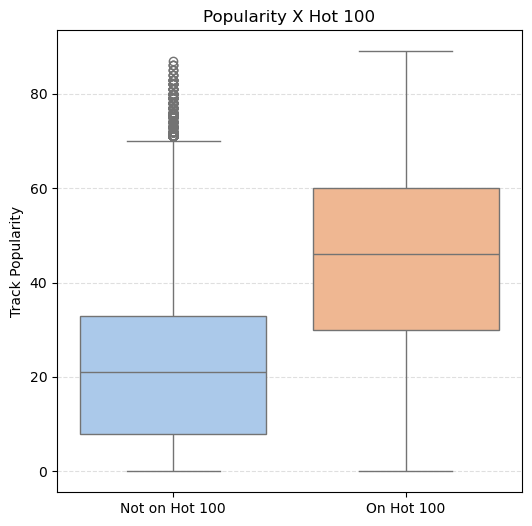

In [38]:
#Some EDA to see if popularity score corresponds with Hot_100

plt.figure(figsize=(6, 6))
sns.boxplot(
    data=spotify,
    x='on_hot100',
    y='popularity',
    palette='pastel'
)

plt.xticks([0, 1], ['Not on Hot 100', 'On Hot 100'])
plt.xlabel('')
plt.ylabel('Track Popularity')
plt.title('Popularity X Hot 100')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

/var/folders/m1/kmxmz7rn0hj40p8qcm94nqf80000gn/T/ipykernel_27699/2417519830.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


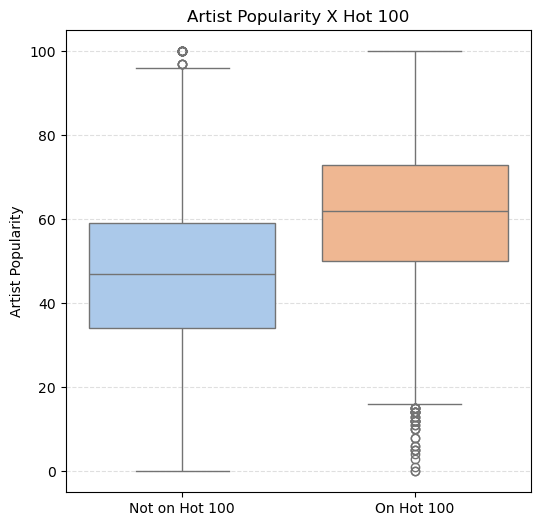

In [39]:
plt.figure(figsize=(6, 6))
sns.boxplot(
    data=spotify,
    x='on_hot100',
    y='artist_popularity',
    palette='pastel'
)

plt.xticks([0, 1], ['Not on Hot 100', 'On Hot 100'])
plt.xlabel('')
plt.ylabel('Artist Popularity')
plt.title('Artist Popularity X Hot 100')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

/var/folders/m1/kmxmz7rn0hj40p8qcm94nqf80000gn/T/ipykernel_27699/3262705187.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


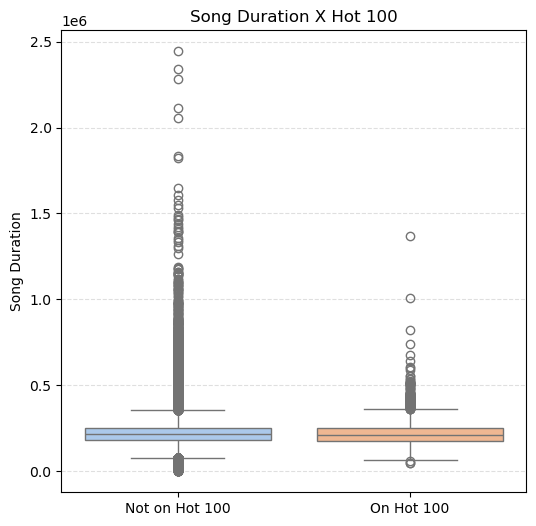

In [40]:
plt.figure(figsize=(6, 6))
sns.boxplot(
    data=spotify,
    x='on_hot100',
    y='duration_ms',
    palette='pastel'
)

plt.xticks([0, 1], ['Not on Hot 100', 'On Hot 100'])
plt.xlabel('')
plt.ylabel('Song Duration')
plt.title('Song Duration X Hot 100')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

In [ ]:
#save spotify final with song key and on_hot100

spotify.to_csv("../Final/popularity_subset/spotify_hot100.csv")
